In [91]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from IPython.display import clear_output

In [ ]:
import os
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from torch.utils.data import DataLoader

In [3]:
from vad.architectures import STAD
from vad.datasets import TrajectoryDataset, ExactBatchSampler

In [95]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


# Methods

## Utilities

In [ ]:
def load_experiment_setups():
    # Load the different setups as dicts based on the folder structure
    setups = list()
    for t_num in range(1, 4):
        path = f'../data/ais/evaluation/type_{t_num}'
        dirs = [f.split('_') for f in os.listdir(path)]
        for i in range(len(dirs)):
            adir = dirs[i]
            if len(adir) == 6:
                d = adir[1]
                r = adir[3]
                p = adir[-1]
                setup = dict(type=t_num, d=d, r=r, p=p)
                setups.append(setup)
            elif len(adir) == 4:
                r = adir[1]
                p = adir[-1]
                setup = dict(type=t_num, r=r, p=p)
                setups.append(setup)
    return setups

## General Scoring

In [ ]:
def score_trajectories(model, dataloader, device):
    """Returns anomaly score for each trajectory in dataloader"""
    model.eval()
    total_val_loss = 0

    loss_per_trj = []
    for batchidx, batch in enumerate(dataloader): # Batch equals trajectory

        # Retrieve trajectory id
        trj_id = batch.get('trajectory_id').pop()

        # Move data to device
        inputs = {k: v.to(device) for k, v in batch.get('src_window').items()}
        targets = {k: v.to(device) for k, v in batch.get('tgt_window').items()}

        # Pass data through model
        loss = model(inputs, targets, training=False)

        loss_per_trj.append((trj_id, loss.item()))

    return loss_per_trj

In [ ]:
def score_experiments(model, device):
    """Returns DataFrame with the ROC AUC score for each experiment in the STAD publication"""

    # Load the different setups as dicts based on the folder structure
    setups = load_experiment_setups()

    # Loading dataset based on experiment setup and use it for calculating ROC-AUC score
    score_frame = pd.DataFrame(columns=['type', 'd', 'r', 'p', 'score'])
    for stp in tqdm(setups):

        # Define dataset, trajectory sampler and dataloader
        ds = TrajectoryDataset(ds_type='test',
                               lat_bins=400,
                               lon_bins=400,
                               sog_bins=30,
                               cog_bins=72,
                               test_config=stp,
                               include_weather=False)

        smplr = ExactBatchSampler(ds.batch_boundaries)
        ldr = DataLoader(ds, batch_sampler=smplr)

        # Get loss per trj
        losses = score_trajectories(model, ldr, device)
        losses_frame = pd.DataFrame(losses, columns=['tid', 'loss'])

        # Load labels for dataset
        labels = np.vstack(ds.labels)
        anom_idx = np.where(labels[:, 0] > 0)[0]
        l = np.zeros((labels.shape[0], ))
        l[anom_idx] = 1
        losses_frame['label'] = l

        min_loss = losses_frame['loss'].min()
        max_loss = losses_frame['loss'].max()
        losses_frame['proba'] = (losses_frame['loss'] - min_loss) / (max_loss - min_loss)

        # Calculate ROC-AUC score
        score = roc_auc_score(losses_frame['label'], losses_frame['proba'])
        params = pd.DataFrame(stp, index=[0])
        params['score'] = score

        # Save results
        score_frame = pd.concat([score_frame, params])
    return score_frame

In [ ]:
def score_experiments_multimodel(device, func, output_dir, gmm_components, threshold_method):
    """Returns DataFrame where each row is a trajectory in one of the experiments"""

    os.makedirs(output_dir, exist_ok=True)

    # Load the different setups as dicts based on the folder structure
    setups = load_experiment_setups()

    for component_value in tqdm(gmm_components, desc="Scoring Different C's"):

        hidden_dim_gmm = int(((component_value - 20) / 20) * 32 + 32)

        # Experiment parameters
        exp_type = 'components'
        include_weather = True
        n_weather_vars = 5

        # Training parameters
        epochs = 100
        patience = epochs
        learning_rate = 1e-5 # Peak LR
        embed_dim = 32
        latent_dim_ae = 32
        weight_decay = 0.1
        dropout = 0.1
        n_head_te = 8
        n_layers_te = 4
        eps_gmm = 1e-7
        eps_loss = 1

        # Definine Model Parameters as in experiment
        model = STAD(
            n_lat_bins=400,
            n_lon_bins=400,
            n_sog_bins=30,
            n_cog_bins=72,
            max_seq_len=10,
            embed_dim=embed_dim,
            dropout=dropout,
            nhead_te=n_head_te,
            n_layers_te=n_layers_te,
            latent_dim_ae=latent_dim_ae,
            n_weather_vars=n_weather_vars,
            hidden_dim_gmm=hidden_dim_gmm,
            eps_gmm=eps_gmm,
            n_components_gmm=component_value).to(device)

        # Load model parameters
        current_model_fp = f'../notebooks/model-training/models/components/{component_value}/STAD_best.pth'

        # Load the checkpoint
        checkpoint = torch.load(current_model_fp, weights_only=False)

        # Load the model state dictionary
        model.load_state_dict(checkpoint['model_state_dict'])

        start_epoch = checkpoint['epoch'] + 1
        best_loss = checkpoint['val_loss']
        print(f"Model loaded successfully from epoch {start_epoch - 1} with validation loss {best_loss:.4f}")

        results = func(model=model, device=device, threshold_method=threshold_method)
        os.makedirs(output_dir, exist_ok=True)
        results.to_csv(os.path.join(output_dir, f'{component_value}.csv'))

        del results

## Unreduced

In [ ]:
def score_experiments_unreduced(model, device):
    """Returns DataFrame where each row is a trajectory in one of the experiments"""

    trj_score_frame = pd.DataFrame(columns=['type', 'd', 'r', 'p', 'trj', 'label', 'loss'])
    result_frames = []

    setups = load_experiment_setups()

    for stp in tqdm(setups):

        # Define dataset, trajectory sampler and dataloader
        ds = TrajectoryDataset(ds_type='test',
                               lat_bins=400,
                               lon_bins=400,
                               sog_bins=30,
                               cog_bins=72,
                               test_config=stp,
                               include_weather=False)

        smplr = ExactBatchSampler(ds.batch_boundaries)
        ldr = DataLoader(ds, batch_sampler=smplr)

        # Get loss per trj
        losses = score_trajectories(model, ldr, device)
        losses_frame = pd.DataFrame(losses, columns=['tid', 'loss'])

        # Load labels for dataset
        labels = np.vstack(ds.labels)
        anom_idx = np.where(labels[:, 0] > 0)[0]
        l = np.zeros((labels.shape[0], ))
        l[anom_idx] = 1

        # Add label to losses frame
        losses_frame['label'] = l

        # Add the type of anomaly
        losses_frame['type'] = stp.get('type')

        # Add deviation of anomaly
        losses_frame['d'] = stp.get('d', None)

        # Add ratio of anomalies
        losses_frame['r'] = stp.get('r')

        # Add num deviating points
        losses_frame['p'] = stp.get('p')

        # Reorder losses frame
        losses_frame = losses_frame[['type', 'd', 'r', 'p', 'tid', 'label', 'loss']]

        # Add to results
        result_frames.append(losses_frame)

    return pd.concat(result_frames, axis=0)

# RQ1

## Methods

### Finding Threshold for Loss

In [ ]:
def find_optimal_threshold(y_true, y_score):
    """
    Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)
    """

    fpr, tpr, thresholds = roc_curve(y_true, y_score)

    # Youden's J = Sensitivity + Specificity - 1 = TPR - FPR
    j_scores = tpr - fpr - 1
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

def find_threshold_normal(df):
    """
    Define threshold based on latent representation of the distribution of negative instances in the test set.
    """
    df = df[df['label'] == 0.0].copy()
    return df['loss'].mean() + (3 * df['loss'].std())

### Calculate all metrics

In [ ]:
def score_experiments_with_confusion_matrix(model, device, threshold_method):
    """
    Returns DataFrame with ROC AUC score and confusion matrix metrics for each experiment

    Parameters:
    - threshold_method: 'optimal' (Youden's J), 'median', or float value
    """

    # Load the different setups as dicts based on the folder structure
    setups = list()
    for t_num in range(1, 4):
        path = f'../data/ais/evaluation/type_{t_num}'
        dirs = [f.split('_') for f in os.listdir(path)]
        for i in range(len(dirs)):
            adir = dirs[i]
            if len(adir) == 6:
                d = adir[1]
                r = adir[3]
                p = adir[-1]
                setup = dict(type=t_num, d=d, r=r, p=p)
                setups.append(setup)
            elif len(adir) == 4:
                r = adir[1]
                p = adir[-1]
                setup = dict(type=t_num, r=r, p=p)
                setups.append(setup)

    # Enhanced columns for confusion matrix metrics
    score_frame = pd.DataFrame(columns=[
        'type', 'd', 'r', 'p', 'roc_auc_score',
        'threshold', 'tn', 'fp', 'fn', 'tp',
        'fpr', 'fnr', 'precision', 'recall', 'f1_score'
    ])

    for stp in tqdm(setups):
        # Define dataset, trajectory sampler and dataloader
        ds = TrajectoryDataset(ds_type='test',
                               lat_bins=400,
                               lon_bins=400,
                               sog_bins=30,
                               cog_bins=72,
                               test_config=stp,
                               include_weather=False)

        smplr = ExactBatchSampler(ds.batch_boundaries)
        ldr = DataLoader(ds, batch_sampler=smplr, num_workers=4, pin_memory=True, persistent_workers=True)

        # Get loss per trajectory
        losses = score_trajectories(model, ldr, device)
        losses_frame = pd.DataFrame(losses, columns=['tid', 'loss'])

        # Load labels for dataset
        labels = np.vstack(ds.labels)
        anom_idx = np.where(labels[:, 0] > 0)[0]
        l = np.zeros((labels.shape[0], ))
        l[anom_idx] = 1
        losses_frame['label'] = l

        # Normalize probabilities
        min_loss = losses_frame['loss'].min()
        max_loss = losses_frame['loss'].max()
        losses_frame['proba'] = (losses_frame['loss'] - min_loss) / (max_loss - min_loss)

        # Calculate ROC-AUC score
        roc_auc = roc_auc_score(losses_frame['label'], losses_frame['loss'])

        # Determine threshold
        if threshold_method == 'optimal':
            threshold = find_optimal_threshold(losses_frame['label'], losses_frame['loss'])
        elif threshold_method == 'median':
            threshold = losses_frame['loss'].median()
        elif threshold_method == 'normal':
            threshold = find_threshold_normal(losses_frame[['loss', 'label']])

        # Convert probabilities to binary predictions
        y_pred = (losses_frame['loss'] >= threshold).astype(int)
        y_true = losses_frame['label'].astype(int)

        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate additional metrics
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0  # False Negative Rate
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        # Prepare results
        params = pd.DataFrame(stp, index=[0])
        params['roc_auc_score'] = roc_auc
        params['threshold'] = threshold
        params['tn'] = tn
        params['fp'] = fp
        params['fn'] = fn
        params['tp'] = tp
        params['fpr'] = fpr
        params['fnr'] = fnr
        params['precision'] = precision
        params['recall'] = recall
        params['f1_score'] = f1

        # Save results
        score_frame = pd.concat([score_frame, params], ignore_index=True)

        clear_output()

    return score_frame

## Scoring

In [ ]:
score_experiments_multimodel(device=device,
                             func=score_experiments_with_confusion_matrix,
                             threshold_method='optimal',
                             output_dir='experiment-results/tables/components/cfs_youden/',
                             gmm_components=[1, 5, 10, 20, 25, 30, 40, 50, 100])


Scoring Different C's: 100%|██████████| 9/9 [13:47<00:00, 91.92s/it]


# RQ2
To what extent does incorporating meteorological variables improve anomaly detection performance compared to AIS-only models?

## Load Models to Test

In [ ]:
PATH_W = 'notebooks/model-training/models/baseweather/STAD_best.pth'
PATH_B = 'notebooks/model-training/models/baseline/STAD_best.pth'

### Baseline

In [15]:
exp_type = 'baseline'
include_weather = False
n_weather_vars = 0
embed_dim = 32
weight_decay = 0.1
dropout = 0.1
epochs = 250
learning_rate = 1e-5
hidden_dim_gmm = 32
latent_dim_ae = 32
patience = epochs
n_head_te = 8
n_layers_te = 4
n_components = 20
eps_gmm = 1e-7
eps_loss = 1

experiment_name = f'{exp_type}_epochs_{epochs}_pat_{patience}_embed_{embed_dim}_wd_{weight_decay}_lr_{learning_rate}_hgmm_{hidden_dim_gmm}_lae_{latent_dim_ae}_comp_{n_components}'
print(experiment_name)

baseline_epochs_250_pat_250_embed_32_wd_0.1_lr_1e-05_hgmm_32_lae_32_comp_20


In [ ]:
model_b = STAD(n_lat_bins=400,
                n_lon_bins=400,
                n_sog_bins=30,
                n_cog_bins=72,
                max_seq_len=10,
                embed_dim=embed_dim,
                dropout=dropout,
                nhead_te=n_head_te,
                n_layers_te=n_layers_te,
                latent_dim_ae=latent_dim_ae,
                n_weather_vars=n_weather_vars,
                hidden_dim_gmm=hidden_dim_gmm,
                eps_gmm=eps_gmm,
                n_components_gmm=n_components).to(device)

# Load the checkpoint
checkpoint = torch.load(PATH_B, weights_only=False)

# Load the model state dictionary
model_b.load_state_dict(checkpoint['model_state_dict'])

start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['val_loss']
print(f"Model loaded successfully from epoch {start_epoch - 1} with validation loss {best_loss:.4f}")

print(model_b)

Model loaded successfully from epoch 247 with validation loss 73.3818
STAD(
  (embedding): TrajectoryEmbedding(
    (lat_embed): Embedding(400, 32)
    (lon_embed): Embedding(400, 32)
    (sog_embed): Embedding(30, 32)
    (cog_embed): Embedding(72, 32)
  )
  (transenc): TrajectoryTransformerEncoder(
    (pos_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affi

### Weather

In [17]:
exp_type = 'baseweather'
include_weather = True
n_weather_vars = 5
embed_dim = 32
weight_decay = 0.1
dropout = 0.1
epochs = 250
learning_rate = 1e-5
hidden_dim_gmm = 32
latent_dim_ae = 32
patience = epochs
n_head_te = 8
n_layers_te = 4
n_components = 30
eps_gmm = 1e-7
eps_loss = 1

experiment_name = f'{exp_type}_epochs_{epochs}_pat_{patience}_embed_{embed_dim}_wd_{weight_decay}_lr_{learning_rate}_hgmm_{hidden_dim_gmm}_lae_{latent_dim_ae}_comp_{n_components}'
print(experiment_name)

baseweather_epochs_250_pat_250_embed_32_wd_0.1_lr_1e-05_hgmm_32_lae_32_comp_30


### Model Instantiation

In [18]:
model_w = STAD(n_lat_bins=400,
            n_lon_bins=400,
            n_sog_bins=30,
            n_cog_bins=72,
            max_seq_len=10,
            embed_dim=embed_dim,
            dropout=dropout,
            nhead_te=n_head_te,
            n_layers_te=n_layers_te,
            latent_dim_ae=latent_dim_ae,
            n_weather_vars=n_weather_vars,
            hidden_dim_gmm=hidden_dim_gmm,
            eps_gmm=eps_gmm,
            n_components_gmm=n_components).to(device)


### Weights Loading

In [19]:
# Load the checkpoint
checkpoint = torch.load(PATH_W, weights_only=False)

# Load the model state dictionary
model_w.load_state_dict(checkpoint['model_state_dict'])

# Optionally, set the epoch
start_epoch = checkpoint['epoch'] + 1
best_loss = checkpoint['val_loss']

print(f"Model loaded successfully from epoch {start_epoch - 1} with best validation loss {best_loss:.4f}")

Model loaded successfully from epoch 221 with best validation loss 89.4305


## Scoring

In [ ]:
tables_odir = './experiment-results/tables/RQ2'
os.makedirs(tables_odir, exist_ok=True)

results_rq2 = []
for model_name, model in zip(['b', 'w'], [model_b, model_w]):
    for t_meth in ['normal', 'optimal']:
        score_frame = score_experiments_with_confusion_matrix(model=model, device=device, threshold_method=t_meth)
        score_frame['model_name'] = model_name
        score_frame['threshold_method'] = t_meth
        fn = f'rq2_model_name_{model_name}_threshold_{t_meth}.csv'
        o_fp = os.path.join(tables_odir, fn)
        score_frame.to_csv(o_fp, index=False)
        results_rq2.append(score_frame)

100%|██████████| 24/24 [01:31<00:00,  3.82s/it]


In [75]:
results_rq2_df = pd.concat(results_rq2, axis=0)

In [76]:
fn = f'rq2_results_all.csv'
o_fp = os.path.join(tables_odir, fn)
results_rq2_df.to_csv(o_fp, index=False)

In [78]:
print(results_rq2_df.shape)
results_rq2_df.head()

(96, 17)


,type,d,r,p,roc_auc_score,threshold,tn,fp,fn,tp,fpr,fnr,precision,recall,f1_score,model_name,threshold_method
0,1,1,0.05,0.05,0.610714,40.051431,766,8,38,1,0.010336,0.974359,0.111111,0.025641,0.041667,b,normal
1,1,1,0.05,0.1,0.588087,40.278826,765,9,39,0,0.011628,1.000000,0.000000,0.000000,0.000000,b,normal
2,1,1,0.05,0.2,0.568065,40.068308,772,9,41,0,0.011524,1.000000,0.000000,0.000000,0.000000,b,normal
3,1,1,0.1,0.05,0.618480,39.954794,735,7,78,2,0.009434,0.975000,0.222222,0.025000,0.044944,b,normal
4,1,1,0.1,0.1,0.551440,40.445154,724,8,81,0,0.010929,1.000000,0.000000,0.000000,0.000000,b,normal


In [90]:
results_rq2_df.pivot_table(index=['threshold_method', 'type', 'd'], columns='model_name', values=['fpr', 'fnr', 'recall', 'f1_score'], aggfunc='mean')

f1_score                 fnr                 fpr  \
model_name                      b         w         b         w         b   
threshold_method type d                                                     
normal           1    1  0.018223  0.024932  0.989450  0.985359  0.010792   
                      2  0.041100  0.026939  0.974786  0.983120  0.010345   
                 2    1  0.041279  0.023941  0.975610  0.985772  0.010314   
                      2  0.113691  0.051785  0.926829  0.967480  0.011097   
optimal          1    1  0.172036  0.170403  0.376443  0.361654  0.437881   
                      2  0.187849  0.226633  0.379060  0.411966  0.257353   
                 2    1  0.205272  0.205925  0.343496  0.365854  0.412293   
                      2  0.279588  0.302476  0.146341  0.178862  0.224925   

                                     recall            
model_name                      w         b         w  
threshold_method type d                                
normal           1    1  0.010803  0.010550  0.014641  
                      2  0.011638  0.025214  0.016880  
                 2    1  0.011179  0.024390  0.014228  
                      2  0.011097  0.073171  0.032520  
optimal          1    1  0.454765  0.623557  0.638346  
                      2  0.185346  0.620940  0.588034  
                 2    1  0.382299  0.656504  0.634146  
                      2  0.193769  0.853659  0.821138

In [79]:
results_rq2_df['d'].value_counts()

d
1    48
2    24
Name: count, dtype: int64

In [63]:
t_meth = 'optimal'
rq2_selected_df = results_rq2_df[results_rq2_df['threshold_method'] == t_meth]
rq2_selected_df['d'] = rq2_selected_df['d'].fillna(value=0)

/scratch-node/20230379.3039489/ipykernel_226665/1531868990.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rq2_selected_df['d'] = rq2_selected_df['d'].fillna(value=0)


In [73]:
rq2_selected_df.pivot_table(columns='model_name', aggfunc='mean', values=['fpr'])

model_name,b,w
fpr,0.409202,0.364693


## Dataset Loading

In [ ]:
traj_dataset_test = TrajectoryDataset(ds_type='test',
                                      lat_bins=400,
                                      lon_bins=400,
                                      sog_bins=30,
                                      cog_bins=72,
                                      test_config={'d': 1, 'r': 0.1, 'p':0.1, 'type': 1},
                                      include_weather=False)

traj_sampler = ExactBatchSampler(traj_dataset_test.batch_boundaries)

test_dataloader = DataLoader(traj_dataset_test, batch_sampler=traj_sampler)

## Scoring Single Experiment

In [68]:
losses = score_trajectories(stad, test_dataloader, device)

Scoring: 100%|██████████| 813/813 [00:07<00:00, 110.84it/s]


### Analyse results

In [69]:
df = pd.DataFrame(losses, columns=['tid', 'loss'])

In [71]:
df['loss'].describe()

count    813.000000
mean      21.565197
std        4.461239
min        7.788124
25%       18.428947
50%       21.664104
75%       24.357204
max       42.139427
Name: loss, dtype: float64

<Axes: ylabel='loss'>

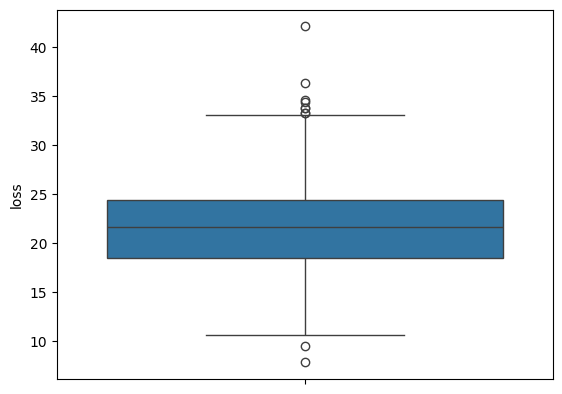

In [72]:
sns.boxplot(df['loss'])

## Score all experiments

In [73]:
experiment_results = score_experiments(stad, device)

Scoring: 100%|██████████| 813/813 [00:06<00:00, 119.54it/s]
/scratch-node/20230379.3029749/ipykernel_2363372/4108780282.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_frame = pd.concat([score_frame, params])
100%|██████████| 24/24 [03:08<00:00,  7.86s/it]


In [74]:
experiment_name = os.path.basename(os.path.dirname(PATH))
experiment_results.to_csv(f'experiment-results/{experiment_name}.csv', index=False)

In [75]:
experiment_results.sort_values(by=['type', 'score'])

,type,d,r,p,score
0,1,1,0.05,0.2,0.531058
0,1,1,0.1,0.05,0.550000
0,1,1,0.05,0.1,0.556516
0,1,1,0.1,0.1,0.566805
0,1,2,0.05,0.2,0.576824
0,1,2,0.05,0.1,0.579010
0,1,2,0.05,0.05,0.579431
0,1,1,0.05,0.05,0.586994
0,1,1,0.1,0.2,0.597472
0,2,1,0.1,0.05,0.508784


## Comparing models

In [78]:
df_base = pd.read_csv('experiment-results/baseline_epochs_100_pat_100_embed_32_wd_0.1_lr_1e-05_hgmm_32_lae_32_comp_20.csv')
df_base['exp'] = 'base'

df_weather = experiment_results
df_weather['exp'] = 'weather'

results = pd.concat([df_base, df_weather], axis=0)

results.groupby(['exp', 'type'])['score'].mean()

exp      type
base     1       0.568291
         2       0.663223
         3       0.657266
weather  1       0.569346
         2       0.663680
         3       0.663073
Name: score, dtype: float64

In [79]:
pt = results.pivot_table(index='type', columns='exp', values='score', aggfunc='mean')
pt['wimprov'] = pt['weather'] - pt['base']
pt

exp,base,weather,wimprov
type,,,
1,0.568291,0.569346,0.001054
2,0.663223,0.663680,0.000457
3,0.657266,0.663073,0.005807


# RQ4
Model Performance under Varying Weather Conditions

In [ ]:
tables_odir_rq4 = 'experiment-results/tables/RQ4'
os.makedirs(tables_odir_rq4, exist_ok='True')
results_rq4 = []

for model_name, model in zip(['b', 'w'], [model_b, model_w]):

    unreduced_results = score_experiments_unreduced(model, device)
    unreduced_results['model_name'] = model_name

    fn = f'rq4_unreduced_model_name_{model_name}.csv'
    o_fp = os.path.join(tables_odir_rq4, fn)
    unreduced_results.to_csv(o_fp, index=False)

    results_rq4.append(unreduced_results)

100%|██████████| 24/24 [01:29<00:00,  3.75s/it]


In [194]:
df = pd.read_parquet('/home/20230379/vessel-anomaly-detection/enrich-ais-metocean/stad/joined-stad-weather-test.parquet')

In [195]:
df.head()

,latitude,longitude,SOG,COG,timestamp,MMSI,traj_id,swh,mwd,mwp,u10,v10
0,37.5945,-123.0155,10.300000,237.500000,1693526406,369037000,369037000_0,2.631632,309.778809,7.228070,9.627502,-8.796371
1,37.5785,-123.0435,9.600000,235.068852,1693527006,369037000,369037000_0,2.631632,309.778809,7.228070,8.520081,-8.645981
2,37.5635,-123.0705,8.762121,248.145455,1693527606,369037000,369037000_0,2.801065,318.052246,7.233685,8.106018,-8.913559
3,37.5605,-123.0995,8.684058,267.317391,1693528206,369037000,369037000_0,2.801065,318.052246,7.233685,8.106018,-8.913559
4,37.5605,-123.1305,8.540580,269.252174,1693528806,369037000,369037000_0,2.801065,318.052246,7.233685,8.106018,-8.913559


In [196]:
len(df['traj_id'].unique())

813

In [197]:
def create_weather_agg(row):
    return row['swh'] + max(
        [abs(row['u10']), abs(row['v10'])]
    )

In [198]:
df['weather_agg'] = df[['swh', 'u10', 'v10']].apply(create_weather_agg, axis=1)

In [199]:
df['weather_agg'].describe()

count    91508.000000
mean         6.826684
std          3.342994
min          1.276598
25%          4.071478
50%          6.120322
75%          9.146691
max         19.259014
Name: weather_agg, dtype: float64

In [284]:
gb_trj = df.groupby('traj_id')['weather_agg'].max()
gb_trj

traj_id
210063000_259    12.058580
210063000_260     9.007792
210063000_261    10.038117
210063000_262    11.718087
210469000_180     5.811900
210777000_231    10.477405
210777000_232    11.657486
212482000_543     5.250566
212482000_544    16.962345
212482000_545    16.990368
212482000_546     5.592590
212656000_78      9.432255
215131000_244     9.891377
215131000_245    13.157496
215137000_791    15.372018
215158000_706    10.905438
215158000_707     8.125603
215159000_750     7.968675
215159000_751    12.722148
215165000_136     7.257730
215165000_137    10.324529
215165000_138     5.153702
215165000_139    10.502073
215183000_246    10.354654
215183000_247     8.290917
215183000_248    12.142148
215240000_587     4.121461
215240000_588     6.115425
215240000_589     5.861794
215240000_590     9.109497
215240000_591    12.017138
215346000_372     8.141262
215346000_373     6.691401
215346000_374    13.090878
215522000_760    14.217144
215560000_524    11.666555
215560000_525     5.

<Axes: xlabel='weather_agg', ylabel='Density'>

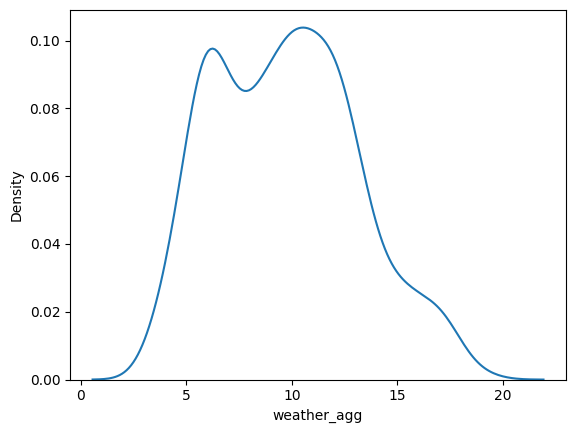

In [301]:
sns.kdeplot(gb_trj)

In [285]:
gb_trj.describe()

count    813.000000
mean       9.712116
std        3.386209
min        3.213905
25%        6.810851
50%        9.661190
75%       12.037918
max       19.259014
Name: weather_agg, dtype: float64

In [313]:
gb_trj.quantile(0/4)

np.float64(3.213904619216919)

In [305]:
min_w = gb_trj.min()
max_w = gb_trj.max()
width = (max_w - min_w) / 3
print(width)

5.348369836807251


In [387]:
bins = [gb_trj.min(), gb_trj.mean(), gb_trj.max()]
print(bins)

[3.213904619216919, np.float32(9.712116), 19.259014129638672]


In [388]:
labels = ['Below Average', 'Above Average']
scored_trjs = pd.cut(gb_trj, bins=bins, labels=labels, include_lowest=True)

In [389]:
scored_trjs

traj_id
210063000_259    Above Average
210063000_260    Below Average
210063000_261    Above Average
210063000_262    Above Average
210469000_180    Below Average
210777000_231    Above Average
210777000_232    Above Average
212482000_543    Below Average
212482000_544    Above Average
212482000_545    Above Average
212482000_546    Below Average
212656000_78     Below Average
215131000_244    Above Average
215131000_245    Above Average
215137000_791    Above Average
215158000_706    Above Average
215158000_707    Below Average
215159000_750    Below Average
215159000_751    Above Average
215165000_136    Below Average
215165000_137    Above Average
215165000_138    Below Average
215165000_139    Above Average
215183000_246    Above Average
215183000_247    Below Average
215183000_248    Above Average
215240000_587    Below Average
215240000_588    Below Average
215240000_589    Below Average
215240000_590    Below Average
215240000_591    Above Average
215346000_372    Below Average


In [390]:
scored_trjs.value_counts()

weather_agg
Below Average    412
Above Average    401
Name: count, dtype: int64

In [391]:
unreduced_results.to_csv('unreduced_results.csv')

In [393]:
len(unreduced_results['tid'].unique())

1488

In [394]:
print(unreduced_results.shape)
unreduced_results.head()

(19611, 8)


,type,d,r,p,tid,label,loss,proba
0,1,1,0.05,0.05,369037000_0,0.0,16.048172,0.218016
1,1,1,0.05,0.05,369037000_1,0.0,20.034016,0.306823
2,1,1,0.05,0.05,369037000_2,0.0,30.079622,0.530643
3,1,1,0.05,0.05,477637600_3,0.0,38.357727,0.715083
4,1,1,0.05,0.05,477637600_4,0.0,25.808224,0.435474


In [395]:
unreduced_results['tid'].value_counts()

tid
248714000_97     24
248714000_98     24
248714000_99     24
248714000_100    24
248714000_101    24
255805854_102    24
255805854_103    24
255805854_104    24
477280900_77     24
636018760_106    24
636018760_107    24
357777000_108    24
357777000_109    24
357777000_110    24
431710000_111    24
431710000_112    24
319211600_113    24
255805854_105    24
212656000_78     24
255806498_79     24
563460000_80     24
220415000_81     24
566071000_82     24
566071000_83     24
566071000_84     24
566071000_85     24
248714000_96     24
566071000_87     24
269806000_88     24
538005271_89     24
538005271_90     24
538005271_91     24
636018092_92     24
636018092_93     24
566414000_94     24
566414000_95     24
566071000_86     24
311000111_134    24
311000111_135    24
215165000_136    24
215165000_137    24
215165000_138    24
215165000_139    24
563187900_140    24
563187900_141    24
319211600_114    24
563187900_143    24
477637600_3      24
369037000_2      24
369037000_1     

In [396]:
merged = unreduced_results.merge(right=scored_trjs, right_index=True, left_on='tid', how='left')

In [397]:
merged = merged.dropna(subset=['weather_agg'])
len(merged['tid'].unique())

813

In [398]:
merged.head()

,type,d,r,p,tid,label,loss,proba,weather_agg
0,1,1,0.05,0.05,369037000_0,0.0,16.048172,0.218016,Above Average
1,1,1,0.05,0.05,369037000_1,0.0,20.034016,0.306823,Above Average
2,1,1,0.05,0.05,369037000_2,0.0,30.079622,0.530643,Below Average
3,1,1,0.05,0.05,477637600_3,0.0,38.357727,0.715083,Below Average
4,1,1,0.05,0.05,477637600_4,0.0,25.808224,0.435474,Below Average


In [ ]:
aggregated = (merged
 .groupby(['type', 'weather_agg'])
 .apply(calc_roc_auc_score)
 .reset_index()
 .pivot_table(index='type', columns='weather_agg')
 .droplevel(axis=1, level=0))

aggregated['Difference'] = aggregated['Above Average'] - aggregated['Below Average']

In [457]:
aggregated.to_csv('gb_weather_aggregated.csv', float_format='%.4f')

In [399]:
merged1 = merged[merged['type'] == 1].drop('type', axis=1)
merged2 = merged[merged['type'] == 2].drop('type', axis=1)
merged3 = merged[merged['type'] == 3].drop('type', axis=1)

In [ ]:
def calc_roc_auc_score(x):
    return roc_auc_score(x['label'], x['proba'])

res1 = merged1.groupby(['d', 'r', 'p', 'weather_agg'])[['loss', 'proba', 'label']].apply(calc_roc_auc_score)
res2 = merged2.groupby(['d', 'r', 'p', 'weather_agg'])[['loss', 'proba', 'label']].apply(calc_roc_auc_score)
res3 = merged3.groupby(['r','p', 'weather_agg'])[['loss', 'proba', 'label']].apply(calc_roc_auc_score)
#res = merged1.groupby(['d','r','p', 'weather_agg','label'])[['loss']].count()

In [ ]:
merged1.groupby(['r', 'weather_agg', 'label'])[['loss']].count()

In [417]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res1)

d  r     p     weather_agg  
1  0.05  0.05  Below Average    0.608858
               Above Average    0.670037
         0.1   Below Average    0.577389
               Above Average    0.614430
         0.2   Below Average    0.684932
               Above Average    0.825758
   0.1   0.05  Below Average    0.565217
               Above Average    0.722488
         0.1   Below Average    0.573025
               Above Average    0.529687
         0.2   Below Average    0.632502
               Above Average    0.575970
2  0.05  0.05  Below Average    0.697902
               Above Average    0.663621
         0.1   Below Average    0.710267
               Above Average    0.735327
         0.2   Below Average    0.721046
               Above Average    0.624414
dtype: float64

In [ ]:
res1_pt = res1.reset_index().pivot_table(index=['d','r','p'], columns='weather_agg')
res1_pt[(0, 'Difference')] = res1_pt[(0, 'Above Average')] - res1_pt[(0, 'Below Average')]
res1_pt = res1_pt.droplevel(axis=1, level=0)
res1_pt.to_csv('type1_gb_weather.csv', float_format='%.4f')
res1_pt

In [434]:
res1_pt.columns[1]

(0, 'Above Average')

In [419]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res2)

d  r     p     weather_agg  
1  0.05  0.05  Below Average    0.746753
               Above Average    0.511111
         0.1   Below Average    0.526667
               Above Average    0.805970
         0.2   Below Average    0.640000
               Above Average    0.460317
   0.1   0.05  Below Average    0.423188
               Above Average    0.669789
         0.1   Below Average    0.565476
               Above Average    0.599462
         0.2   Below Average    0.655556
               Above Average    0.602151
2  0.05  0.05  Below Average    0.786667
               Above Average    0.945312
         0.1   Below Average    0.759459
               Above Average    0.878788
         0.2   Below Average    0.872807
               Above Average    0.940299
dtype: float64

In [ ]:
res2_pt = res2.reset_index().pivot_table(index=['d','r','p'], columns='weather_agg')
res2_pt[(0, 'Difference')] = res2_pt[(0, 'Above Average')] - res2_pt[(0, 'Below Average')]
res2_pt.to_csv('type2_gb_weather.csv', float_format='%.4f')
res2_pt

In [421]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(res3)

r     p     weather_agg  
0.05  0.05  Below Average    0.663622
            Above Average    0.607605
      0.1   Below Average    0.722589
            Above Average    0.742034
      0.2   Below Average    0.678671
            Above Average    0.768639
0.1   0.05  Below Average    0.577735
            Above Average    0.667800
      0.1   Below Average    0.715255
            Above Average    0.663211
      0.2   Below Average    0.781398
            Above Average    0.766854
dtype: float64

In [ ]:
res3_pt = res3.reset_index().pivot_table(index=['r','p'], columns='weather_agg')
res3_pt[(0, 'Difference')] = res3_pt[(0, 'Above Average')] - res3_pt[(0, 'Below Average')]
res3_pt = res3_pt.droplevel(axis=1, level=0)
res3_pt.to_csv('type3_gb_weather.csv', float_format='%.4f')
res3_pt

In [447]:
res3_pt.index

MultiIndex([('0.05', '0.05'),
            ('0.05',  '0.1'),
            ('0.05',  '0.2'),
            ( '0.1', '0.05'),
            ( '0.1',  '0.1'),
            ( '0.1',  '0.2')],
           names=['r', 'p'])

In [ ]:
def compare_weather_robustness(model_without_weather, model_with_weather, device, threshold=0.5):
    """
    Compare false positive rates between models with and without weather data
    """

    # Get results for both models
    results_no_weather = score_experiments_with_confusion_matrix(model_without_weather, device, threshold)
    results_with_weather = score_experiments_with_confusion_matrix(model_with_weather, device, threshold)

    # Add model identifier
    results_no_weather['model'] = 'without_weather'
    results_with_weather['model'] = 'with_weather'

    # Combine results
    combined_results = pd.concat([results_no_weather, results_with_weather], ignore_index=True)

    # Calculate improvement in FPR
    comparison = []
    for setup in results_no_weather[['type', 'd', 'r', 'p']].drop_duplicates().to_dict('records'):
        # Filter for specific setup
        mask = True
        for key, value in setup.items():
            if pd.notna(value):  # Handle NaN values for experiments without 'd'
                mask &= (combined_results[key] == value)
            else:
                mask &= pd.isna(combined_results[key])

        setup_results = combined_results[mask]

        if len(setup_results) == 2:  # Both models have results
            fpr_no_weather = setup_results[setup_results['model'] == 'without_weather']['fpr'].iloc[0]
            fpr_with_weather = setup_results[setup_results['model'] == 'with_weather']['fpr'].iloc[0]

            fpr_improvement = fpr_no_weather - fpr_with_weather  # Positive = improvement
            fpr_improvement_pct = (fpr_improvement / fpr_no_weather * 100) if fpr_no_weather > 0 else 0

            comparison.append({
                **setup,
                'fpr_without_weather': fpr_no_weather,
                'fpr_with_weather': fpr_with_weather,
                'fpr_improvement': fpr_improvement,
                'fpr_improvement_pct': fpr_improvement_pct
            })

    return pd.DataFrame(comparison), combined_results

def plot_confusion_matrix_comparison(results_df, setup_filter=None, figsize=(12, 8)):
    """
    Plot confusion matrix comparison between models
    """
    if setup_filter:
        filtered_results = results_df.copy()
        for key, value in setup_filter.items():
            filtered_results = filtered_results[filtered_results[key] == value]
    else:
        filtered_results = results_df

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    for i, model in enumerate(['without_weather', 'with_weather']):
        model_data = filtered_results[filtered_results['model'] == model]

        if len(model_data) > 0:
            # Aggregate confusion matrix values
            tn = model_data['tn'].sum()
            fp = model_data['fp'].sum()
            fn = model_data['fn'].sum()
            tp = model_data['tp'].sum()

            cm = np.array([[tn, fp], [fn, tp]])

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Normal', 'Anomaly'],
                       yticklabels=['Normal', 'Anomaly'],
                       ax=axes[i])
            axes[i].set_title(f'Model {model.replace("_", " ").title()}')
            axes[i].set_ylabel('True Label')
            axes[i].set_xlabel('Predicted Label')

            # Add FPR to title
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            axes[i].set_title(f'{axes[i].get_title()}\nFPR: {fpr:.3f}')

    plt.tight_layout()
    plt.show()

    return fig